In [7]:
import pyrox
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import os
from pathlib import Path
from typing import Optional, Iterable
import seaborn as sns
sns.set_style('darkgrid')

In [8]:
client = pyrox.PyroxClient()

STATIONS = [
    "skiErg_time","sledPush_time","sledPull_time","burpeeBroadJump_time",
    "rowErg_time","farmersCarry_time","sandbagLunges_time","wallBalls_time"
]
RUNS = [f"run{i}_time" for i in range(1, 9)]
ALL_SPLITS = STATIONS + RUNS + ["run_time", "total_time"]
def clean_times(df, lower_q=0.0001, upper_q=0.99):
    """
    Cleans unrealistic Hyrox split times.
    - Converts to numeric
    - Removes 0s or > total_time
    - Removes extreme outliers per station/run via quantiles
    """
    df = df.copy()
    df[ALL_SPLITS] = df[ALL_SPLITS].apply(pd.to_numeric, errors="coerce")
    # Drop if any station/run time = 0 or > total_time
    for col in ALL_SPLITS:
        df = df[(df[col] > 0) & (df[col] <= df["total_time"])]

    # Remove per-column outliers using quantiles
    for col in ALL_SPLITS:
        low, high = df[col].quantile(lower_q), df[col].quantile(upper_q)
        print(f"Cleaning {col}...\nHave identified value {low} as low threshold and {high} as high threshold.")
        df = df[(df[col] >= low) & (df[col] <= high)]

    print(f"After cleaning and outlier removal: {len(df)} rows.")
    return df

def filter_top(df, col="total_time", pct=1):
    df = df.copy()
    df[col] = pd.to_numeric(df[col], errors="coerce")
    cutoff = df[col].quantile(pct)
    print(f"cutoff has ben set as: {cutoff}")
    return df[df[col] <= cutoff]
def full_clean(df):
    filtered_df = filter_top(df, col="total_time")
    cleaned_df = clean_times(filtered_df)
    return cleaned_df

In [11]:
s7 = client.get_season(season=7, division='open')
s7 = full_clean(s7)

cutoff has ben set as: 1791.4666666666667
Cleaning skiErg_time...
Have identified value 1.180326666666667 as low threshold and 6.25 as high threshold.
Cleaning sledPush_time...
Have identified value 0.9 as low threshold and 5.583333333333333 as high threshold.
Cleaning sledPull_time...
Have identified value 1.0260783333333334 as low threshold and 10.516666666666667 as high threshold.
Cleaning burpeeBroadJump_time...
Have identified value 0.05 as low threshold and 13.316666666666666 as high threshold.
Cleaning rowErg_time...
Have identified value 2.8552766666666667 as low threshold and 6.633333333333334 as high threshold.
Cleaning farmersCarry_time...
Have identified value 0.5927066666666667 as low threshold and 4.083333333333333 as high threshold.
Cleaning sandbagLunges_time...
Have identified value 0.2633466666666668 as low threshold and 10.516666666666667 as high threshold.
Cleaning wallBalls_time...
Have identified value 0.5728566666666667 as low threshold and 13.766666666666667 as 

In [12]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Iterable

GENDER_COLORS = {
    "male": "C0",
    "female": "C1",
}

def _safename(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9._-]+", "_", str(s)).strip("_")[:80]

def _to_minutes(x: pd.Series) -> pd.Series:
    x = pd.to_numeric(x, errors="coerce")
    if x.dropna().median() > 300:
        x = x / 60.0
    return x

def _group_stats_array(vals: np.ndarray) -> tuple[float, float, int]:
    vals = vals[np.isfinite(vals) & (vals > 0)]
    if vals.size == 0:
        return np.nan, np.nan, 0
    mu = float(vals.mean())
    sd = float(vals.std(ddof=0))
    return mu, sd, int(vals.size)

def plot_distributions_by_event(
    df: pd.DataFrame,
    outdir: str = "event_distributions",
    min_per_gender: int = 20,
    events: Optional[Iterable[str]] = None,
    bins: int | str = "auto",
    title_suffix: str = "",
) -> pd.DataFrame:
    """
    Create ONE figure per event_name:
      - Left panel: total_time (by gender)
      - Right panel: work_time (by gender)
    Overlaid histograms per gender, with mean (solid) and ±1 SD (dashed) markers.
    Returns a small summary DataFrame with counts used per event/gender.
    """
    req = {"event_name","gender","total_time","work_time"}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    os.makedirs(outdir, exist_ok=True)

    # Clean copy
    data = df.copy()
    data["total_time_min"] = _to_minutes(data["total_time"])
    data["work_time_min"]  = _to_minutes(data["work_time"])

    # Basic filtering
    data = data.dropna(subset=["event_name","gender","total_time_min","work_time_min"])
    if events is not None:
        data = data[data["event_name"].isin(events)]

    # Prepare summary collector
    summary_rows = []

    # Iterate by event
    for ev, g_ev in data.groupby("event_name", sort=False):
        # Counts by gender to decide inclusion
        counts = g_ev["gender"].value_counts()
        keep_genders = counts[counts >= min_per_gender].index.tolist()
        if len(keep_genders) == 0:
            continue

        g_ev = g_ev[g_ev["gender"].isin(keep_genders)]
        if len(g_ev) < 2:
            continue

        # Build shared bins (fairness)
        tt = g_ev["total_time_min"].to_numpy()
        wt = g_ev["work_time_min"].to_numpy()

        tt_bins = bins
        wt_bins = bins
        if isinstance(bins, int):
            tt_bins = np.histogram_bin_edges(tt, bins=bins)
            wt_bins = np.histogram_bin_edges(wt, bins=bins)

        # ---------- Figure ----------
        fig = plt.figure(figsize=(12, 4.8))
        fig.suptitle(f"{ev} {title_suffix}".strip(), fontsize=14)
        # Panel A: total_time
        ax1 = fig.add_subplot(1, 2, 1)
        for gen, g in g_ev.groupby("gender"):
            vals = g["total_time_min"].to_numpy()
            vals = vals[np.isfinite(vals) & (vals > 0)]
            if len(vals) >= min_per_gender:
                ax1.hist(vals, bins=tt_bins, density=False, alpha=0.5, label=f"{gen} (n={len(vals)})", color=GENDER_COLORS[gen])
                mu, sd, _ = _group_stats_array(vals)
                if np.isfinite(mu):
                    # mean solid
                    ax1.axvline(mu, linestyle="-", linewidth=2, label=f"{gen} total_time average", color=GENDER_COLORS[gen])
        ax1.set_xlabel("Finish time (minutes)")
        ax1.set_ylabel("Count")
        ax1.set_title("Total time distribution")
        ax1.legend(loc="best", frameon=False)
        # Panel B: work_time
        ax2 = fig.add_subplot(1, 2, 2)
        for gen, g in g_ev.groupby("gender"):
            vals = g["work_time_min"].to_numpy()
            vals = vals[np.isfinite(vals) & (vals > 0)]
            if len(vals) >= min_per_gender:
                ax2.hist(vals, bins=wt_bins, density=False, alpha=0.5, label=f"{gen} (n={len(vals)})", color=GENDER_COLORS[gen])
                mu, sd, _ = _group_stats_array(vals)
                if np.isfinite(mu):
                    # mean (solid)
                    ax2.axvline(mu, linestyle="-", linewidth=2, label=f"{gen} work_time average", color=GENDER_COLORS[gen])

        ax2.set_xlabel("Work time (minutes)")
        ax2.set_ylabel("Count")
        ax2.set_title("Work time distribution")
        ax2.legend(loc="best", frameon=False)

        fig.tight_layout(rect=[0, 0, 1, 0.95])
        fname = os.path.join(outdir, f"event_{_safename(ev)}.png")
        plt.show()
        fig.savefig(fname, dpi=150)
        # CHANGED: remove plt.show() for batch runs; keep files cleanly written
        # plt.show()
        plt.close(fig)

        # Collect summary
        for gen in keep_genders:
            n_gen = int((g_ev["gender"] == gen).sum())
            summary_rows.append({"event_name": ev, "gender": gen, "n_used": n_gen, "outfile": fname})

    summary = pd.DataFrame(summary_rows).sort_values(["event_name","gender"])
    return summary

### Analysing run times / station times at different events

Below, choosing a mix of events

- Need to keep the analysis fairly small, so we are not building > 70 graphs - but also ensure we are getting enough data and a god variety across regions
- 2024 London - large field, benchmark European course
- 2024 Dalls - North American Event - worth inspecting differences vs Europe?
- 2024 Paris - Another big EU race, but this time outside the UK, which is arguably the Hyrox hub in Europe
- 2025 Berlin - known for being a fast course. Also held in Germany, country where Hyrox first started
- 2025 Shanghai - Aisan Event - same reasoning as choosing Dallas can be applied
- 2025 Johannesburg - Oceania Event - same reasoning as choosing Dallas can be applied

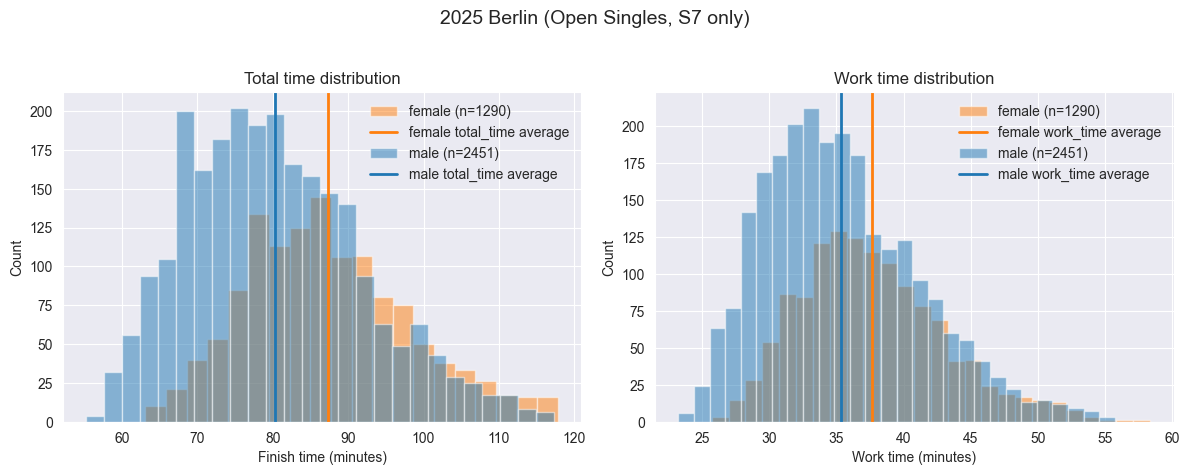

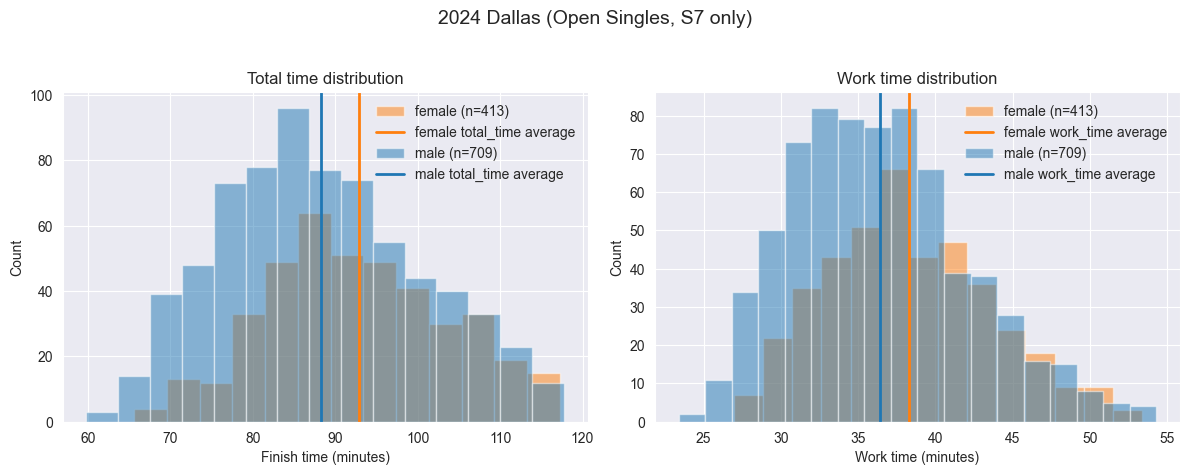

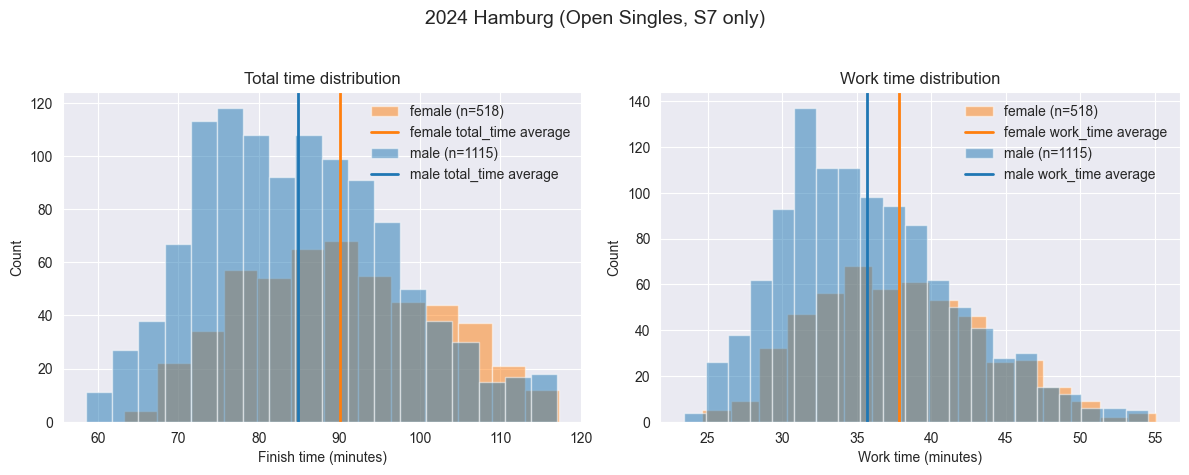

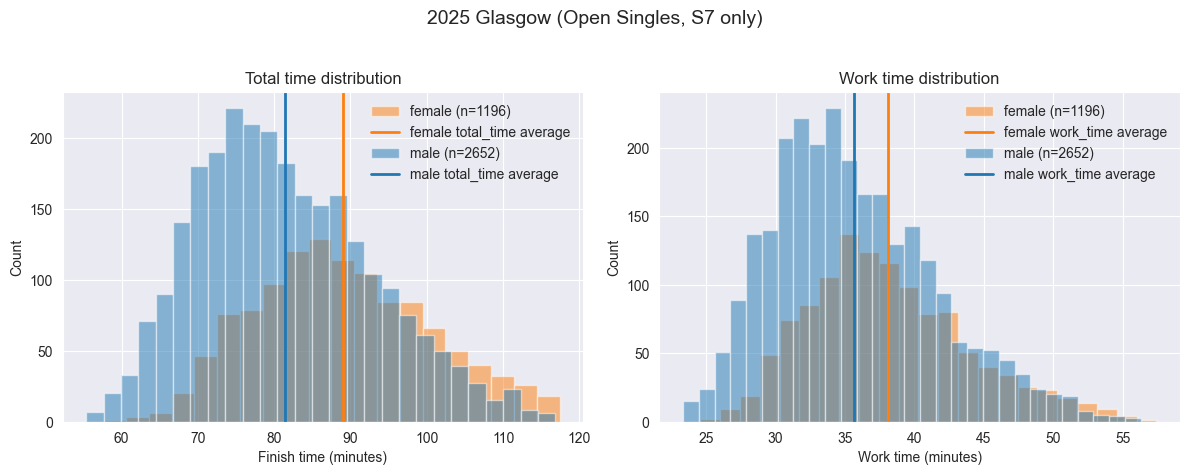

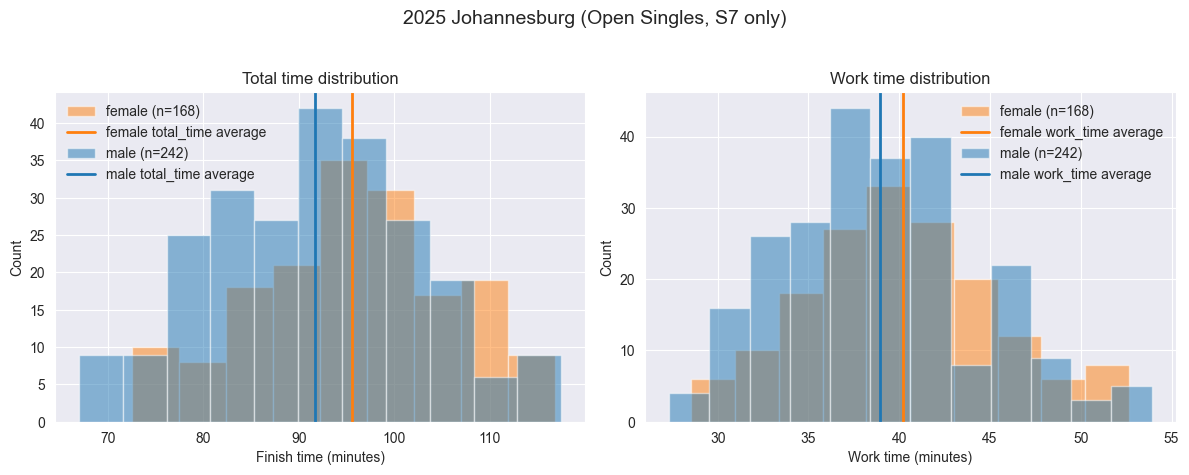

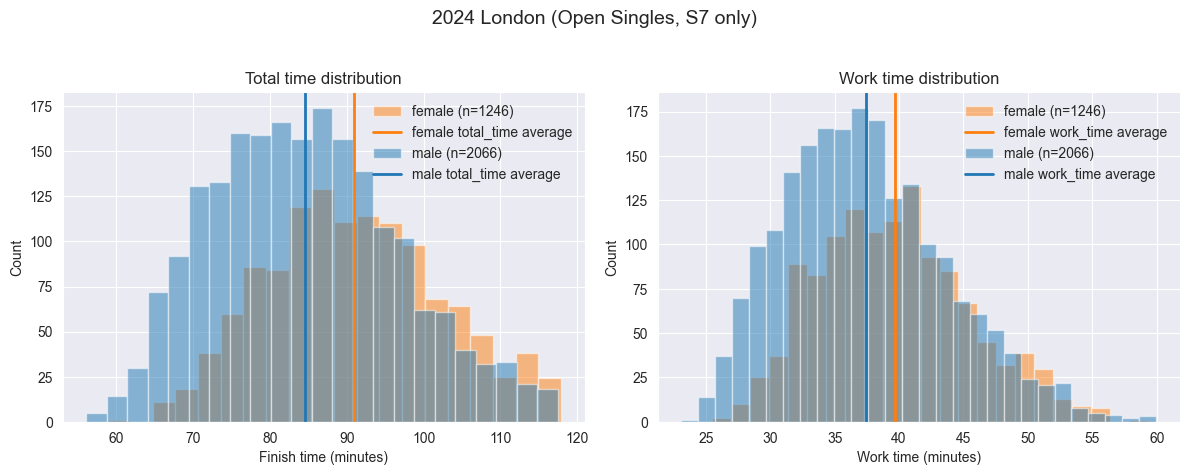

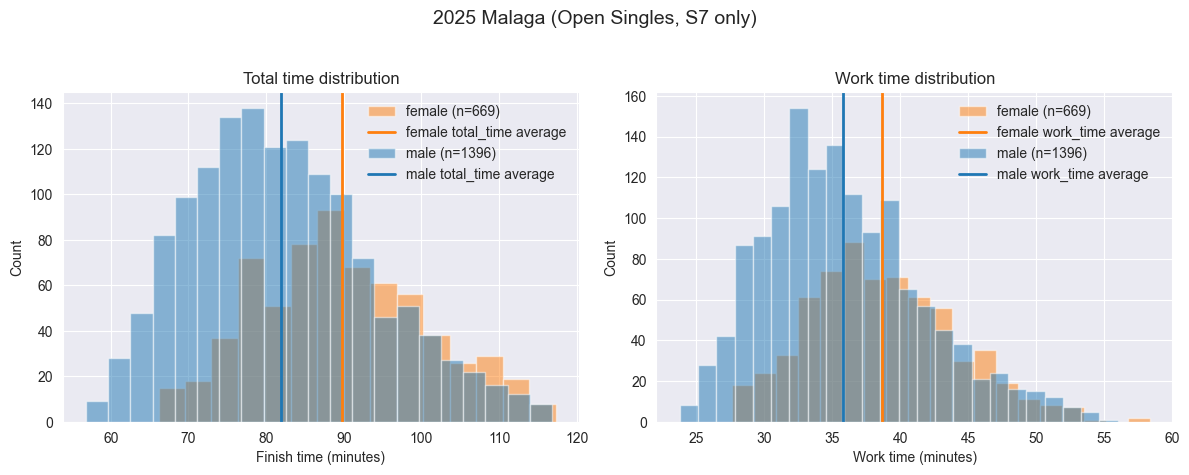

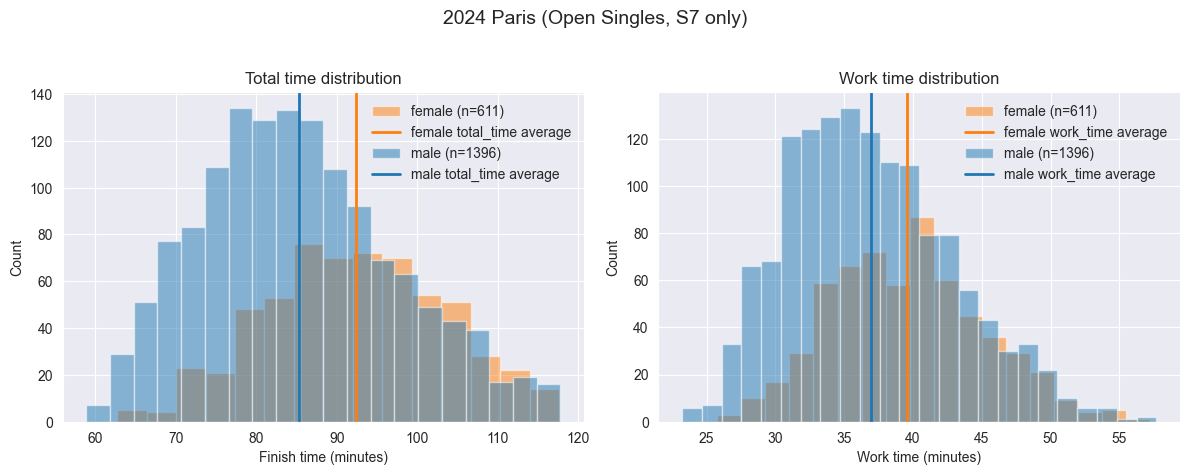

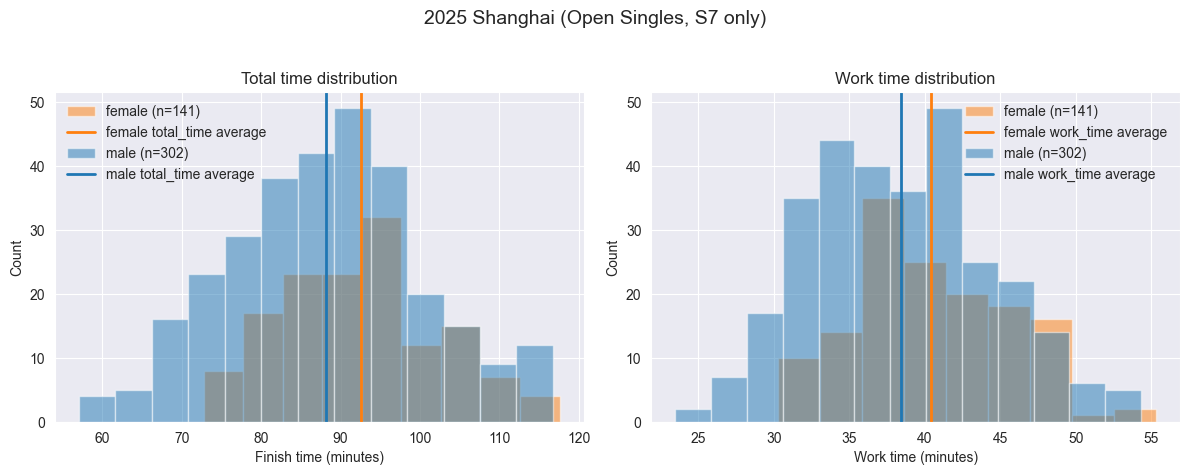

      event_name  gender  n_used                             outfile
3    2024 Dallas  female     413   event_dists/event_2024_Dallas.png
2    2024 Dallas    male     709   event_dists/event_2024_Dallas.png
5   2024 Hamburg  female     518  event_dists/event_2024_Hamburg.png
4   2024 Hamburg    male    1115  event_dists/event_2024_Hamburg.png
11   2024 London  female    1246   event_dists/event_2024_London.png


In [13]:
events_to_analyse = ['2024 London', '2024 Paris', '2024 Dallas', '2025 Berlin', '2025 Shanghai', '2025 Johannesburg', '2025 London', '2025 Glasgow', '2024 Hamburg', '2025 Malaga']
s7_subset = s7.loc[s7.event_name.isin(events_to_analyse)]
#  Reasons for choosing -- Field Size
summary = plot_distributions_by_event(
    s7_subset,
    outdir="event_dists",
    min_per_gender=20,
    bins="auto",
    title_suffix="(Open Singles, S7 only)"
)
print(summary.head())